In [1]:
import gammapy
print(gammapy.__version__ , " == 1")

0.1.dev19174+g56b5bdf  == 1


In [2]:
import numpy as np
import os
import astropy
from astropy import units as u
import matplotlib.pyplot as plt

from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

from collections import OrderedDict
from astropy import units
from gammapy.data import DataStore
from astropy.io import fits
from astropy.coordinates import SkyCoord
from gammapy.data import FixedPointingInfo, Observation, DataStore, observatory_locations
from astropy.coordinates import SkyOffsetFrame
from gammapy.maps import WcsNDMap, WcsGeom, MapAxis, Map
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.datasets import MapDataset
from gammapy.irf import load_cta_irfs, EDispKernel, PSFKernel
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Models,
    FoVBackgroundModel,
    PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
)
from regions import CircleSkyRegion, RectangleSkyRegion


In [3]:
pks_pos = SkyCoord(frame = "galactic",l =  "17.74 deg", b= "-52.25 deg")
pks_pos = SkyCoord("21h58m43.2s", "-30d13m18s")


In [4]:
try:
    models  = Models.read('../standard_model.yml')
except:
    st_model = SkyModel(spatial_model = PointSpatialModel(lon_0 = pks_pos.l.deg *u.deg, lat_0 =  pks_pos.b.deg * u.deg),
                       spectral_model = PowerLawSpectralModel())
    Models(st_model).write("../standard_model.yml")
    models  = Models.read('../standard_model.yml')
    

In [5]:
dataset_public = MapDataset.read('dataset-stacked.fits.gz')
empty = dataset_public.copy()


path = '/home/wecapstor1/caph/mppi045h/fits_paper_data/std_fullEnclosure/pks2155_flare/out'
data_store = DataStore.from_dir(path, f'hdu-index-bg-v05-fov-radec.fits.gz', f'obs-index-bg-v05-fov-radec.fits.gz')
observations = data_store.get_observations(data_store.obs_ids)


In [6]:
timeobs = []
for obs in observations:
    timeobs.append(obs.obs_info['TSTOP']-obs.obs_info['TSTART'])
timeobs = timeobs * u.s
print(timeobs.to(u.hr))
print(np.sum(timeobs).to(u.hr))

[0.46916667 0.46916667 0.46888889 0.46944444 0.46916667 0.46888889
 0.46916667 0.46888889 0.46916667 0.46916667 0.46916667 0.46916667
 0.46916667 0.46916667 0.46916667] h
7.036944444444444 h


In [7]:
angle = []
for obs in observations:
    angle.append(90-obs.obs_info['ALT_PNT'])
np.mean(angle), np.std(angle)

(27.71530848379798, 13.632264528378185)

In [8]:
n_public_runs = len(observations)
location = observatory_locations['hess']

livetime_stereo = 50.089999999999996 *u.hr
livetime_mono = 29.94 * u.hr
livetime_simu = 100 * u.hr # livetime_stereo + livetime_mono
livetime_public =np.sum(timeobs).to(u.hr)
print('public:', livetime_public)
print('simu:', livetime_simu)
def compute_factor(livetime_simu):
    factors =( (livetime_simu/n_public_runs) / timeobs ).to("")
    return factors
factors = compute_factor(livetime_simu)
print("factors", factors)

public: 7.036944444444444 h
simu: 100.0 h
factors [14.20959147 14.20959147 14.21800948 14.20118343 14.20959147 14.21800948
 14.20959147 14.21800948 14.20959147 14.20959147 14.20959147 14.20959147
 14.20959147 14.20959147 14.20959147]


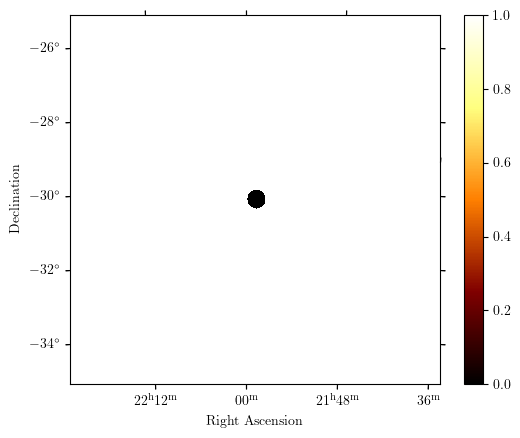

In [9]:

radius = 0.25*u.deg
skyregion = CircleSkyRegion(center=pks_pos, radius=radius)
excl_regions = [skyregion]
geom = dataset_public.geoms['geom']
excl_mask_2d = Map.from_geom(dataset_public.geoms['geom'].to_image(),
                             data=dataset_public.geoms['geom'].to_image().region_mask(excl_regions, inside=False).data)
excl_mask_2d.plot(add_cbar = 1, vmin =0, vmax = 1);

maxthreshold  = 1*u.TeV
ebins = np.logspace(-1,2,25) *u.TeV
max_offset = 2 *u.deg

In [10]:
ra_pnt, dec_pnt = [], []
for obs in observations:
    ra_pnt.append(obs.obs_info['RA_PNT'])
    dec_pnt.append(obs.obs_info['DEC_PNT'])


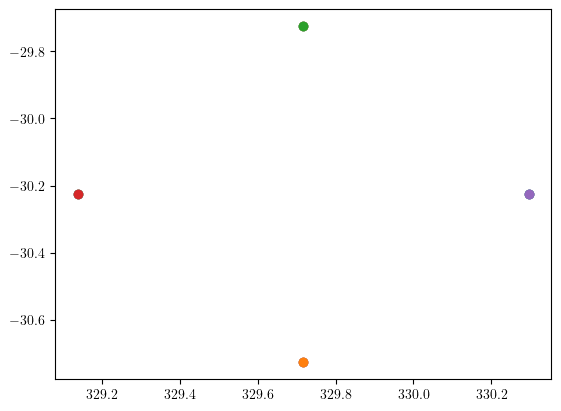

In [11]:
for i in range(len(observations)):
    plt.scatter(ra_pnt[i], dec_pnt[i])

In [12]:
def create(factors):

    datasets = []
    for i in range(n_public_runs ):
        print(i)
        dataset_obs = MapDataset.read(f'dataset-obs-{observations[i].obs_id}.fits.gz')
        #dataset_obs.counts.sum_over_axes().plot(add_cbar =1 )    
        irfs = {'bkg':dataset_obs.background * factors[i],
           'aeff': dataset_obs.exposure * factors[i],#/ livetime ,
           'psf': dataset_obs.psf,
           'edisp': dataset_obs.edisp,
           'rad_max': 4 *u.deg }

        pointing  = observations[i].pointing_radec

        obs = Observation.create(
            pointing=pointing, livetime=timeobs[i], irfs=irfs, location=location
        )

        # Make the MapDataset
        maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

        maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)
        reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)    

        dataset = maker.run(reference, obs)
        dataset = maker_safe_mask.run(dataset, obs)

        dataset.counts.data = dataset.counts.data.astype(np.float32)
        dataset.psf = dataset_obs.psf
        dataset.edisp = dataset_obs.edisp

        datasets.append(dataset)

    dataset_stacked = datasets[0].copy()
    for d in datasets[1:]:
        dataset_stacked.stack(d)
    return datasets, dataset_stacked


In [14]:
datasets, dataset_stacked = create(factors)


0


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cu

1


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cu

2


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cu

3


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cu

4


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cu

5


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cu

6


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cu

7


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cu

8


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cu

9


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cu

10


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cu

11


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cu

12


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cu

13


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cu

14


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cu

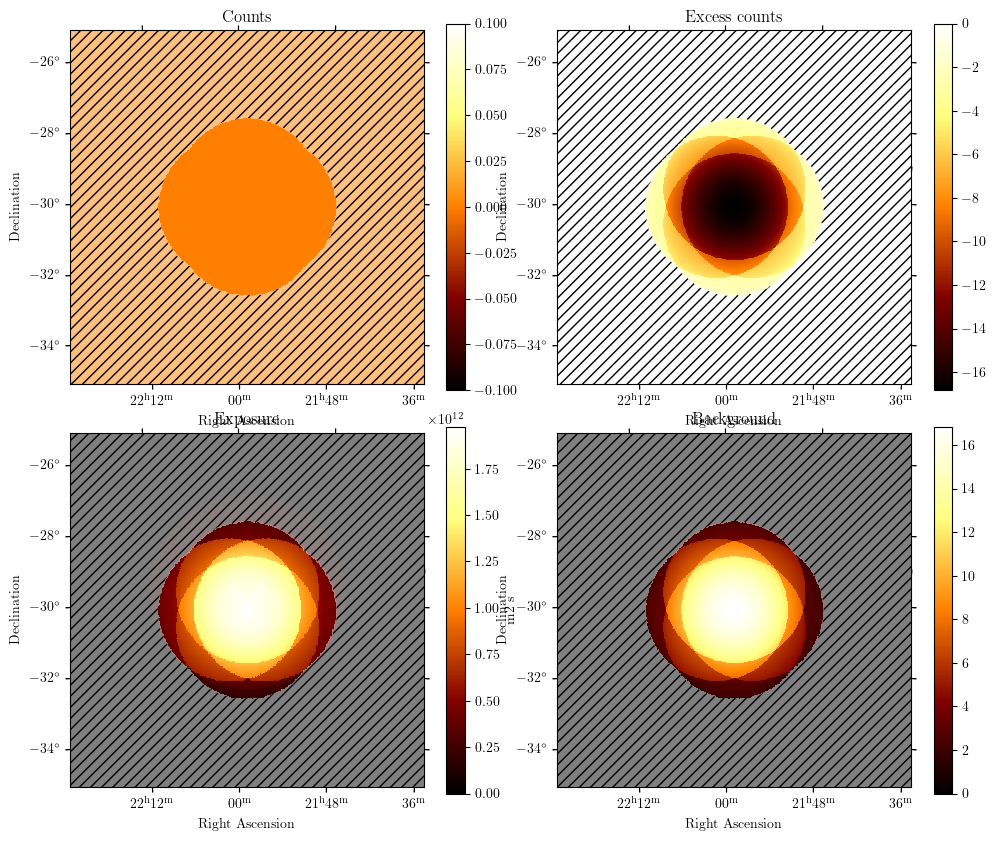

In [15]:
dataset_stacked.peek()

In [16]:
emask = dataset_stacked.mask.data.sum(axis=2).sum(axis=1) >0
emask = dataset_stacked.mask.geom.axes[0].center[emask]

## Simulated different observation times 

In [ ]:
livetime_simus = np.logspace(0, 2, 7) *u.hr

for l in livetime_simus[-2:]:
    print("Livetime: ", l)
    
    factors_ = compute_factor(l)
    datasets_, dataset_stacked_ = create(factors_)
    dataset_stacked_.write(f"dataset-simulated-{l.value}-hr.fits.gz", overwrite= True)

Livetime:  46.41588833612777 h
0


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may

1


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may

2


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may

3


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may

4


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may

5


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may

6


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may

7


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may

8


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may

9


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may

10


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may

11


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may

12


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may

13


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may

14


/tmp/ipykernel_1064373/729146882.py:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  pointing  = observations[i].pointing_radec
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(
/tmp/ipykernel_1064373/729146882.py:24: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may